In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt

# Step 1: Get list of S&P 500 tickers
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tickers_df = pd.read_html(sp500_url)[0]
tickers = tickers_df['Symbol'].tolist()

In [3]:
# Step 2: Download and clean data for each stock
def download_data(ticker, start="2018-01-01", end="2024-12-31"):
    data = yf.download(ticker, start=start, end=end)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

stock_data = {}
for ticker in tickers:
    try:
        df = download_data(ticker)
        if not df.empty:
            stock_data[ticker] = df.dropna()
    except Exception as e:
        print(f"Failed to download {ticker}: {e}")

# ✅ Print the list of tickers used in training
print("✅ Stocks used in training:")
for ticker in stock_data.keys():
    print(ticker)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

✅ Stocks used in training:
MMM
AOS
ABT
ABBV
ACN
ADBE
AMD
AES
AFL
A
APD
ABNB
AKAM
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AEE
AEP
AXP
AIG
AMT
AWK
AMP
AME
AMGN
APH
ADI
ANSS
AON
APA
APO
AAPL
AMAT
APTV
ACGL
ADM
ANET
AJG
AIZ
T
ATO
ADSK
ADP
AZO
AVB
AVY
AXON
BKR
BALL
BAC
BAX
BDX
BBY
TECH
BIIB
BLK
BX
BK
BA
BKNG
BSX
BMY
AVGO
BR
BRO
BLDR
BG
BXP
CHRW
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CARR
CAT
CBOE
CBRE
CDW
COR
CNC
CNP
CF
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CFG
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CAG
COP
ED
STZ
CEG
COO
CPRT
GLW
CPAY
CTVA
CSGP
COST
CTRA
CRWD
CCI
CSX
CMI
CVS
DHR
DRI
DVA
DAY
DECK
DE
DELL
DAL
DVN
DXCM
FANG
DLR
DFS
DG
DLTR
D
DPZ
DASH
DOV
DOW
DHI
DTE
DUK
DD
EMN
ETN
EBAY
ECL
EIX
EW
EA
ELV
EMR
ENPH
ETR
EOG
EPAM
EQT
EFX
EQIX
EQR
ERIE
ESS
EL
EG
EVRG
ES
EXC
EXE
EXPE
EXPD
EXR
XOM
FFIV
FDS
FICO
FAST
FRT
FDX
FIS
FITB
FSLR
FE
FI
F
FTNT
FTV
FOXA
FOX
BEN
FCX
GRMN
IT
GE
GEHC
GEV
GEN
GNRC
GD
GIS
GM
GPC
GILD
GPN
GL
GDDY
GS
HAL
HIG
HAS
HCA
DOC
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HST
HW

In [4]:
# Step 3: Create sliding windows for each stock
def create_sequences(data, window_size=10):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    X, y = [], []
    for i in range(len(data_scaled) - window_size):
        X.append(data_scaled[i:i + window_size])
        y.append(data_scaled[i + window_size][3])  # Close price
    return np.array(X), np.array(y), scaler

window_size = 10
all_X, all_y = [], []

for ticker, df in stock_data.items():
    X, y, _ = create_sequences(df, window_size)
    all_X.append(X)
    all_y.append(y)

X_all = np.concatenate(all_X)
y_all = np.concatenate(all_y)

In [5]:
# Step 4: Train-test split
split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [6]:
# Step 5: Build and train LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 149s 12ms/step - loss: 0.0027 - val_loss: 3.0211e-04
Epoch 2/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 134s 12ms/step - loss: 3.0389e-04 - val_loss: 2.7679e-04
Epoch 3/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 132s 12ms/step - loss: 2.9465e-04 - val_loss: 2.7702e-04
Epoch 4/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 129s 12ms/step - loss: 2.9422e-04 - val_loss: 2.8014e-04
Epoch 5/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 131s 12ms/step - loss: 2.9172e-04 - val_loss: 3.0191e-04
Epoch 6/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 128s 12ms/step - loss: 2.8744e-04 - val_loss: 3.2147e-04
Epoch 7/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 137s 13ms/step - loss: 2.9223e-04 - val_loss: 2.7390e-04
Epoch 8/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 133s 12ms/step - loss: 2.8721e-04 - val_loss: 2.7703e-04
Epoch 9/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 134s 12ms/step - loss: 2.9124e-04 - val_loss: 2.8572e-04
Epoch 10/15
10758/10758 ━━━━━━━━━━━━━━━━━━━━ 134s 12ms/step - loss: 2.8704e-04 - val_loss: 2.74

5379/5379 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step

📉 Test MSE: 2.5936
📉 Test MAE: 1.0677


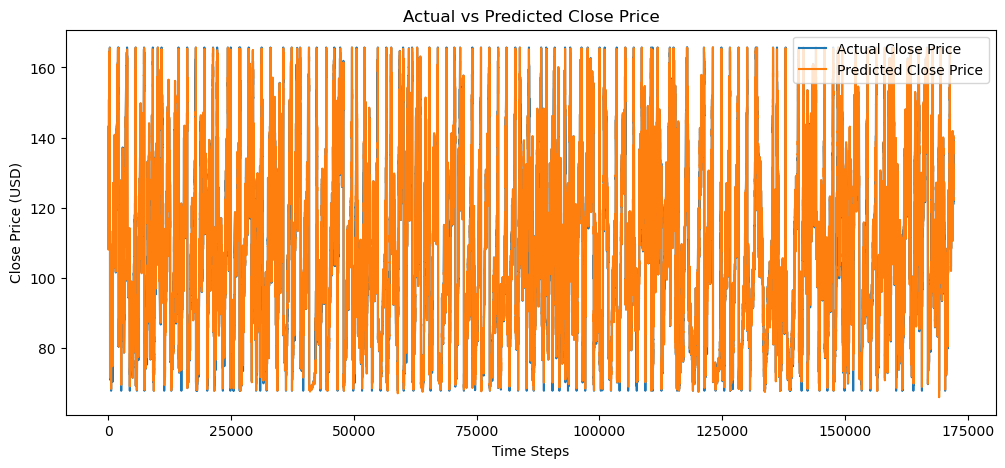

In [7]:
# Step 6: Evaluation
y_pred = model.predict(X_test)

# Use 'Close' scaler from any one stock (same logic applies)
sample_df = list(stock_data.values())[0]
_, _, scaler = create_sequences(sample_df, window_size)
close_min = scaler.data_min_[3]
close_range = scaler.data_range_[3]

y_test_unscaled = y_test * close_range + close_min
y_pred_unscaled = y_pred.flatten() * close_range + close_min

# Metrics
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)

print(f"\n📉 Test MSE: {mse:.4f}")
print(f"📉 Test MAE: {mae:.4f}")

# Plot prediction vs actual
plt.figure(figsize=(12, 5))
plt.plot(y_test_unscaled, label='Actual Close Price')
plt.plot(y_pred_unscaled, label='Predicted Close Price')
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Time Steps")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()